# Processamento de Linguagem Natural (NLP)

Professor: Arlindo Galvão

* Implementação da tokenização


In [120]:
!pip install datasets -q
!pip install regex -q
!pip install transformers -q

## Carregando bibliotecas

In [121]:
import regex as re
from transformers import GPT2Tokenizer
import matplotlib.pyplot as plt

## **Questão 1**

1.a) Crie um tokenizador com o algoritmo Byte Pair Encoding num corpus português. Sugestão de dataset UFRGS/brwac<br /><br />

1.b) Adicione um regex antes do BPE para melhorar o merge do BPE.(exemplo: GPT4).
<br /><br />
GPT4_SPLIT_PATTERN = r"""'(?i:[sdmt]|ll|ve|re)|[^\r\n\p{L}\p{N}]?+\p{L}+|\p{N}{1,3}| ?[^\s\p{L}\p{N}]++[\r\n]*|\s*[\r\n]|\s+(?!\S)|\s+"""


<br /><br />


1.c) Faça uma analise gráfica entre a relação de tokens do documento (link abaixo) e o tamanho do vocabulário. <br />
  Exemplo: eixo x variando [1000, 4000, ..., vocab_size]
           eixo y com a qnt de tokens obtidas


<br /><br />

1.d) Tokenize o documento abaixo com algum tokenizador consolidado e compare a tokenização com os tokenizadores customizados.

<br /><br />

Documento a ser tokenizado ao fim (https://pastebin.com/kVzLLUCV)


**Dica**: utilize como ponto de partida a codificação UTF-8 com 256 caracteres.

## Carregando dataset

In [ ]:
def get_dataset(file_path, max_samples=100000):
    # Extrair uma amostra do dataset
    subset = []
    with open(file_path, "r", encoding="utf-8") as file:
        for i, linha in enumerate(file):
            if i >= max_samples:
                break
            subset.append(linha.strip())

    # Unir as linhas do subset em um único texto
    text = ' '.join(subset)

    # Limpeza do texto: Remover tags XML, caracteres especiais e espaços extras
    text = re.sub(r'<[^>]+>', '', text)  # Remove tags XML
    text = re.sub(r'<g/>', ' ', text)    # Substitui <g/> por espaço
    text = re.sub(r'\s+', ' ', text)     # Remove múltiplos espaços
    text = re.sub(r'\s([,.!?])', r'\1', text)  # Remove espaços antes de pontuações

    # Substituição de datas, horas e valores monetários por placeholders
    text = re.sub(r'\b\d{1,2} de \w+ de \d{4}\b', '<DATE>', text)  # Datas completas
    text = re.sub(r'\b\d{1,2}:\d{2}\b', '<TIME>', text)            # Horas
    text = re.sub(r'R\$[ ]?\d+(?:[.,]\d+)*', '<PRICE>', text)      # Valores monetários
    text = re.sub(r'\b\d+\b', '<NUM>', text)                       # Números isolados

    # Remoção de informações irrelevantes, como "Visualizado X vezes"
    text = re.sub(r'\bVisualizado \d+ vezes\b', '', text)

    # Segmentação em frases
    sentences = [sent.strip() for sent in text.split('.') if sent.strip()]

    return sentences

In [71]:
file_path = "brwac.vert"

subset = []
max_samples = 100000

# Ler e processar o arquivo .vert
with open(file_path, "r", encoding="utf-8") as file:
    for i, linha in enumerate(file):
        if i >= max_samples:
            break
        subset.append(linha.strip())

print(subset[0])

<doc docid="netg-1afc73" title="ESPUMA MARROM CHAMADA ‟NINGUÃÂM MERECE‟ - paulo soavinski" uri="http://blogoosfero.cc/ilhadomel/pousadasilhadomel.com.br/espuma-marrom-chamada-ninguem-merece">


O dataset veio em um formato que não é o mais adequado para a tokenização, por exemplo, temos links, tags, etc. Vamos limpar o dataset para que possamos tokenizar de forma mais eficiente. 

In [72]:
text = ' '.join(subset)

# Remover tags XML e caracteres especiais
text = re.sub(r'<[^>]+>', '', text)  # Remove tags XML
text = re.sub(r'<g/>', ' ', text)    # Substitui <g/> por espaço

# Remover espaços extras e normalizar pontuação
text = re.sub(r'\s+', ' ', text)  # Remove múltiplos espaços
text = re.sub(r'\s([,.!?])', r'\1', text)  # Remove espaços antes de pontuações

# Substituir datas, horas e valores monetários por placeholders
'''text = re.sub(r'\b\d{1,2} de \w+ de \d{4}\b', '<DATE>', text)  # Substitui datas completas
text = re.sub(r'\b\d{1,2}:\d{2}\b', '<TIME>', text)  # Substitui horas
text = re.sub(r'R\$[ ]?\d+(?:[.,]\d+)*', '<PRICE>', text)  # Substitui valores monetários
text = re.sub(r'\b\d+\b', '<NUM>', text)  # Substitui números isolados por <NUM>'''

# Opcional: Remover informações irrelevantes como "Visualizado 202 vezes"
text = re.sub(r'\bVisualizado \d+ vezes\b', '', text)

# Segmentar o texto em frases
sentences = [sent.strip() for sent in text.split('.') if sent.strip()]

In [73]:
for sentence in sentences:
    print(sentence)

Conteúdo recente ESPUMA MARROM CHAMADA " NINGUÉM MERECE " 31 de Agosto de 2015, 7:07, por paulo soavinski - | No one following this article yet
JORNAL ELETRÔNICO DA ILHA DO MEL Uma espuma marrom escuro tem aparecido com frequência na Praia de Fora
Na faixa de areia ela aparece disseminada e não chama muito a atenção
No Buraco do Aipo, com muitas pedras, ela aparece concentrada
É fácil saber que esta espuma estranha está lá, quando venta
Pequenos algodões de espuma começam a flutuar no espaço, pertinho da Praia do Saquinho
Quem pode ajudar na coleta deste material, envio a laboratório renomado e pagamento de análises, favor entrar em contato com o site
Praça Eugenio Jardim, Rio de Janeiro ( Capital ) Praça Eugenio Jardim, Rio de Janeiro, Rio de Janeiro R$1
400 Descrição Ótimo apartamento em Copacabana, no corte do Cantagalo, bem em frente ao metrô, próximo à lagoa e à praia
Muito bem localizado, uma área nobre
O apartamento é bem espaçoso, tem 3 quartos e uma dependência, cozinha, área 

## Questão 1

### 1.a) Tokenizador com BPE

In [79]:
def get_stats(ids, counts=None):
    """
    Given a list of integers, return a dictionary of counts of consecutive pairs
    Example: [1, 2, 3, 1, 2] -> {(1, 2): 2, (2, 3): 1, (3, 1): 1}
    Optionally allows to update an existing dictionary of counts
    """
    counts = {} if counts is None else counts
    for pair in zip(ids, ids[1:]): # iterate consecutive elements
        counts[pair] = counts.get(pair, 0) + 1
    return counts


def merge(ids, pair, idx):
    """
    In the list of integers (ids), replace all consecutive occurrences
    of pair with the new integer token idx
    Example: ids=[1, 2, 3, 1, 2], pair=(1, 2), idx=4 -> [4, 3, 4]
    """
    newids = []
    i = 0
    while i < len(ids):
        # if not at the very last position AND the pair matches, replace it
        if ids[i] == pair[0] and i < len(ids) - 1 and ids[i+1] == pair[1]:
            newids.append(idx)
            i += 2
        else:
            newids.append(ids[i])
            i += 1
    return newids


class BPETokenizer():
    def __init__(self):
        self.vocab = {idx: bytes([idx]) for idx in range(256)}
        self.vocab_size = 256
        self.merges = {}


    def train(self, text, vocab_wished):
        if vocab_wished < 256:
            raise ValueError('Vocab size must be greater than 256')

        num_merges = vocab_wished - self.vocab_size
        ids = list(map(int, text.encode('utf-8')))

        self.merges = {}

        for i in range(num_merges):
            stats = get_stats(ids)

            if not stats:
                print("Não há mais pares para fundir.")
                break
            
            best = max(stats, key=stats.get)
            print(f'Best pair: {best} with frequency {stats[best]} into {self.vocab_size}')
            ids = merge(ids, best, self.vocab_size)
            self.merges[best] = self.vocab_size
            self.vocab_size += 1

        for (p0, p1), idx in self.merges.items():
            self.vocab[idx] = self.vocab[p0] + self.vocab[p1]



    def encode(self, text):
        tokens = list(map(int, text.encode('utf-8')))


        while len(tokens) > 1:
            stats = get_stats(tokens)
            pair = min(stats, key=lambda p: self.merges.get(p, float('inf')))

            if pair not in self.merges:
                break

            idx = self.merges[pair]

            tokens = merge(tokens, pair, idx)

        return tokens



    def decode(self, ids):
        tokens = b"".join([self.vocab[idx] for idx in ids])
        text = tokens.decode('utf-8', errors='replace') # Nem todas sequências de bytes são válidas seguindo o utf-8, quando isso ocorrer, substituiremos por um caracter especial
        return text

In [80]:
tokenizer = BPETokenizer()
tokenizer.train(text, 1000)

Best pair: (111, 32) with frequency 11527 into 256
Best pair: (97, 32) with frequency 11173 into 257
Best pair: (101, 32) with frequency 10678 into 258
Best pair: (115, 32) with frequency 7812 into 259
Best pair: (44, 32) with frequency 5868 into 260
Best pair: (109, 32) with frequency 4241 into 261
Best pair: (101, 110) with frequency 3707 into 262
Best pair: (100, 258) with frequency 3682 into 263
Best pair: (97, 114) with frequency 3516 into 264
Best pair: (101, 114) with frequency 3467 into 265
Best pair: (101, 115) with frequency 3390 into 266
Best pair: (97, 110) with frequency 3134 into 267
Best pair: (111, 114) with frequency 3033 into 268
Best pair: (46, 32) with frequency 2839 into 269
Best pair: (111, 259) with frequency 2725 into 270
Best pair: (113, 117) with frequency 2687 into 271
Best pair: (99, 111) with frequency 2633 into 272
Best pair: (100, 256) with frequency 2606 into 273
Best pair: (105, 110) with frequency 2480 into 274
Best pair: (195, 163) with frequency 2296

### 1.b) Adicionando regex

In [84]:
print(tokenizer.encode("Rio de Janeiro"))

[819, 357, 74, 267, 341, 111]


In [85]:
tokenizer.vocab

{0: b'\x00',
 1: b'\x01',
 2: b'\x02',
 3: b'\x03',
 4: b'\x04',
 5: b'\x05',
 6: b'\x06',
 7: b'\x07',
 8: b'\x08',
 9: b'\t',
 10: b'\n',
 11: b'\x0b',
 12: b'\x0c',
 13: b'\r',
 14: b'\x0e',
 15: b'\x0f',
 16: b'\x10',
 17: b'\x11',
 18: b'\x12',
 19: b'\x13',
 20: b'\x14',
 21: b'\x15',
 22: b'\x16',
 23: b'\x17',
 24: b'\x18',
 25: b'\x19',
 26: b'\x1a',
 27: b'\x1b',
 28: b'\x1c',
 29: b'\x1d',
 30: b'\x1e',
 31: b'\x1f',
 32: b' ',
 33: b'!',
 34: b'"',
 35: b'#',
 36: b'$',
 37: b'%',
 38: b'&',
 39: b"'",
 40: b'(',
 41: b')',
 42: b'*',
 43: b'+',
 44: b',',
 45: b'-',
 46: b'.',
 47: b'/',
 48: b'0',
 49: b'1',
 50: b'2',
 51: b'3',
 52: b'4',
 53: b'5',
 54: b'6',
 55: b'7',
 56: b'8',
 57: b'9',
 58: b':',
 59: b';',
 60: b'<',
 61: b'=',
 62: b'>',
 63: b'?',
 64: b'@',
 65: b'A',
 66: b'B',
 67: b'C',
 68: b'D',
 69: b'E',
 70: b'F',
 71: b'G',
 72: b'H',
 73: b'I',
 74: b'J',
 75: b'K',
 76: b'L',
 77: b'M',
 78: b'N',
 79: b'O',
 80: b'P',
 81: b'Q',
 82: b'R',
 83: b'

O exemplo acima mostra que o tokenizador faz algumas coisas que são indesejadas, para resolver problemas como esses, podemos aplicar um código regex, que irá retornar uma lista de palavras, e assim, elas serão contabilizadas na tokenização de maneira independente.

In [167]:
GPT4_SPLIT_PATTERN = r"""'(?i:[sdmt]|ll|ve|re)|[^\r\n\p{L}\p{N}]?+\p{L}+|\p{N}{1,3}| ?[^\s\p{L}\p{N}]++[\r\n]*|\s*[\r\n]|\s+(?!\S)|\s+"""


class BPETokenizerRegex():
    def __init__(self, pattern=None):
        self.pattern = GPT4_SPLIT_PATTERN if pattern is None else pattern
        self.compiled_pattern = re.compile(self.pattern)
        self.vocab = {idx: bytes([idx]) for idx in range(256)}
        self.vocab_size = 256
        self.merges = {}


    def train(self, text, vocab_wished):
        if vocab_wished < 256:
            raise ValueError('Vocab size must be greater than 256')

        num_merges = vocab_wished - self.vocab_size

        text_chunks = re.findall(self.compiled_pattern, text)

        ids = [list(ch.encode("utf-8")) for ch in text_chunks]

        self.merges = {}

        for i in range(num_merges):
            stats = {}
            for chunk_ids in ids:
                # passing in stats will update it in place, adding up counts
                get_stats(chunk_ids, stats)

            if not stats:
                print("Não há mais pares para fundir.")
                break

            best = max(stats, key=stats.get)
            #print(f'Best pair: {best} with frequency {stats[best]} into {self.vocab_size}')
            
            ids = [merge(chunk_ids, best, self.vocab_size) for chunk_ids in ids]
            self.merges[best] = self.vocab_size
            self.vocab_size += 1

        for (p0, p1), idx in self.merges.items():
            self.vocab[idx] = self.vocab[p0] + self.vocab[p1]
        
        print('END')



    def encode(self, text):
        tokens = list(map(int, text.encode('utf-8')))


        while len(tokens) > 1:
            stats = get_stats(tokens)
            pair = min(stats, key=lambda p: self.merges.get(p, float('inf')))

            if pair not in self.merges:
                break

            idx = self.merges[pair]

            tokens = merge(tokens, pair, idx)

        return tokens



    def decode(self, ids):
        tokens = b"".join([self.vocab.get(idx, b'\xef\xbf\xbd') for idx in ids]) # Se o índice não existir, substituímos por um caracter especial
        text = tokens.decode('utf-8', errors='replace') # Nem todas sequências de bytes são válidas seguindo o utf-8, quando isso ocorrer, substituiremos por um caracter especial
        return text
    
    
    def tokenize(self, text):
        tokens_bpe = self.encode(text)
        return [self.decode([token]) for token in tokens_bpe]

In [168]:
tokenizer = BPETokenizerRegex()
tokenizer.train(text, 300)

END


In [169]:
print(tokenizer.encode("rio de janeiro"))

[114, 105, 111, 263, 32, 106, 97, 110, 101, 105, 293]


In [170]:
print(tokenizer.tokenize("rio de janeiro"))

['r', 'i', 'o', ' de', ' ', 'j', 'a', 'n', 'e', 'i', 'ro']


### Carregando dataset para análise

In [108]:
file_path = "CPUGPU.txt"

with open(file_path, 'r', encoding='utf-8') as file:
    text_cpu_gpu = file.read()

In [109]:
print(text_cpu_gpu[:1000])

O que é uma CPU?

Construída a partir de bilhões de transistores, a unidade central de processamento (CPU) pode ter vários núcleos de processamento e é comumente referida como o “cérebro” do computador. Ela é essencial para todos os sistemas modernos de computação, pois executa os comandos e processos necessários para o seu computador e para o sistema operacional. A CPU também é importante para determinar a que velocidade os programas podem ser executados ao executarem tarefas, como surfar na web, realizar cálculos para física de jogos e outros programas, ou construir planilhas.

O que é uma GPU?

A unidade de processamento de gráficos (GPU) tem muitos núcleos menores e mais especializados. Esses núcleos oferecem desempenho sólido, trabalhando em conjunto e dividindo tarefas de processamento entre muitos núcleos simultaneamente (ou em paralelo). A GPU destaca-se em tarefas altamente paralelas, como renderização de visuais durante a jogabilidade, manipulação de dados de vídeo durante a 

### 1.c) Análise gráfica

In [112]:
# Supondo que a classe BPETokenizerRegex e o método train já estão definidos
# e que o texto text_cpu_gpu é carregado como uma string

# Definir a função de análise gráfica
def analyze_token_count_vs_vocab_size(tokenizer_class, text_train, text_test ,max_vocab_size):
    vocab_sizes = list(range(256, max_vocab_size + 1, 10))
    tokens_count = []

    # Avaliar a quantidade de tokens para cada tamanho de vocabulário
    for vocab_size in vocab_sizes:
        print(vocab_size)
        tokenizer = tokenizer_class()  # Inicializa o tokenizador
        tokenizer.train(text, vocab_size)  # Treina o tokenizador com o tamanho de vocabulário desejado
        tokens = tokenizer.encode(text)  # Tokeniza o texto
        tokens_count.append(len(tokens))  # Conta a quantidade de tokens gerada

    # Gráfico da relação entre o tamanho do vocabulário e a quantidade de tokens
    plt.plot(vocab_sizes, tokens_count, marker='o')
    plt.xlabel('Tamanho do Vocabulário')
    plt.ylabel('Quantidade de Tokens')
    plt.title('Relação entre Tamanho do Vocabulário e Quantidade de Tokens')
    plt.grid(True)
    plt.show()

# Exemplo de uso:
# analyze_token_count_vs_vocab_size(BPETokenizerRegex, text_cpu_gpu, BPETokenizerRegex.vocab_size)


256
END
266
END
276
END
286
END
296
END
306
END
316
END
326
END
336
END
346
END
356
END
366
END
376
END
386
END
396
END
406
END
416
END
426
END
436
END
446
END
456
END
466
END
476
END
486
END
496
END
506
END
516
END
526
END
536
END
546
END
556
END
566
END
576
END
586
END
596
END
606
END
616
END
626
END
636
END
646
END
656
END
666
END
676
END
686
END
696
END
706
END
716
END
726
END
736
END
746
END
756
END
766
END
776
END
786
END
796
END
806
END
816
END
826
END
836
END
846
END
856
END
866
END
876
END
886
END
896
END
906
END
916
END
926
END
936
END
946
END
956
END
966
END
976
END
986
END
996
END


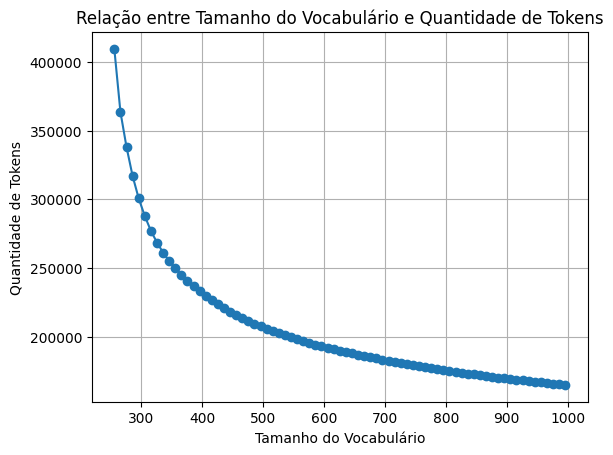

In [113]:
analyze_token_count_vs_vocab_size(BPETokenizerRegex, text ,text_cpu_gpu, 1000)

Por que não podemos crescer o vocab_size até o infinito: <br />
Se crescermos indeferidamente o tamanho do vocab_size, nossa linear que realiza a classificação do próximo token previsto também crescera, além de crescer tambem a layer de embedding,
tornando o modelo muito maior em questão de parâmetros. Além disso, cada token seria cada vez mais raramente encontrado no dataset, além disso, estariamos comprimindo documentos completos em um único token, o que não é o ideal, pois começa a aparecer uma questão de localidade, onde dois documentos muito semelhantes, com apenas uma palavra diferente, teriam que ser tratados como documentos completamente diferentes, o que não é o ideal.


Por outro lado, um número muito pequeno de tokens (utf-8 por exemplo) resultaria em sequencias muito longas, o que também não é o ideal, pois precisariamos de uma janela de contexto muito grande para manter a coesão. Além disso, processariamos muito mais sequências durante o treino e inferencia, como também perderiamos possibilidades interessantes, por exemplo um token que representa uma conjução verbal.

### 1.d) Tokenização do documento

In [171]:
gpt2_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

In [172]:
tokenizer = BPETokenizerRegex()
tokenizer.train(text, 2000)

END


Temos os dois tokenizadores, vamos comparar a tokenização de um texto com ambos.

In [173]:
frases = ['rio de janeiro',
          'inteligência artificial',
          'bacharelado',
          'processamento de linguagem natural']


for frase in frases:
    print('Frase: ', frase)
    print("GPT-2:", gpt2_tokenizer.tokenize(frase))
    print("BPE Customizado:", tokenizer.tokenize(frase))
    print('\n\n')

Frase:  rio de janeiro
GPT-2: ['rio', 'Ġde', 'Ġj', 'ane', 'iro']
BPE Customizado: ['rio', ' de', ' j', 'an', 'eiro']



Frase:  inteligência artificial
GPT-2: ['intel', 'ig', 'Ãª', 'nc', 'ia', 'Ġartificial']
BPE Customizado: ['i', 'nt', 'el', 'ig', 'ência', ' ar', 'ti', 'fic', 'ial']



Frase:  bacharelado
GPT-2: ['bach', 'arel', 'ado']
BPE Customizado: ['ba', 'c', 'ha', 're', 'l', 'ado']



Frase:  processamento de linguagem natural
GPT-2: ['process', 'ament', 'o', 'Ġde', 'Ġlingu', 'ag', 'em', 'Ġnatural']
BPE Customizado: ['p', 'ro', 'c', 'es', 'sa', 'mento', ' de', ' l', 'inguagem', ' na', 'tura', 'l']





É possível perceber palavras especificas, como bacharelado, que provavelmente não aparecem no texto de treino, possuem muitos tokens, que não necessáriamente fazem sentido na divisão. 
Já rio de janeiro, que aparece com maior frequencia no dataset já possui uma representação mais adequada, inclusive mais próxima do tokenizer do gpt-2.

In [174]:
results = [(frase, "✔️" if all(word in text for word in frase.split()) else "❌") for frase in frases]

In [175]:
for word, status in results:
    print(f"{word}: {status}")

rio de janeiro: ✔️
inteligência artificial: ❌
bacharelado: ❌
processamento de linguagem natural: ❌


Podemos ver que a unica frase que possui todas palavras no corpus é "rio de janeiro".

In [176]:
ids_before_tokenization = list(text_cpu_gpu.encode('utf-8'))

gpt2_tokens = gpt2_tokenizer.tokenize(text_cpu_gpu)
bpe_tokens = tokenizer.tokenize(text_cpu_gpu)

gpt2_vocab_size = len(gpt2_tokenizer.get_vocab())
bpe_vocab_size = tokenizer.vocab_size

print(f"Quantidade de IDs no texto antes da tokenização (UTF-8): {len(ids_before_tokenization)}")

print('\n')

print(f"GPT-2 - Número de Tokens: {len(gpt2_tokens)}")
print(f"BPE Customizado - Número de Tokens: {len(bpe_tokens)}")

print('\n\n\n')

print(f"Tamanho do Vocabulário GPT-2: {gpt2_vocab_size}")
print(f"Tamanho do Vocabulário BPE Customizado: {bpe_vocab_size}")

Quantidade de IDs no texto antes da tokenização (UTF-8): 4269


GPT-2 - Número de Tokens: 1491
BPE Customizado - Número de Tokens: 1538




Tamanho do Vocabulário GPT-2: 50257
Tamanho do Vocabulário BPE Customizado: 2000


Percebemos que temos uma quantidade semelhante de tokens entre o tokenizador do gpt-2 e o tokenizador customizado, porém, o vocabulário do tokenizador customizado é muito menor, obvio que estamos levando em conta o treinamento em um contexto esoecifico (lingua portuguesa), que não é o caso do gpt-2, que foi treinado em algumas linguas diferentes, codigo e etc.

Isso pode evidenciar que trabalhar em um contexto específico pode nos proporcionar um vocabulário menor, porém mais eficiente, onde lá na ponta (llm) teriamos um desempenho melhor com menor custo

In [181]:
gpt2_token_lengths = [len(token) for token in gpt2_tokens]
avg_gpt2_token_length = sum(gpt2_token_lengths) / len(gpt2_token_lengths)

bpe_decoded_tokens = tokenizer.tokenize(text_cpu_gpu) 
bpe_token_lengths = [len(token) for token in bpe_decoded_tokens]
avg_bpe_token_length = sum(bpe_token_lengths) / len(bpe_token_lengths)

print(f"Tamanho Médio dos Tokens GPT-2: {avg_gpt2_token_length}")
print(f"Tamanho Médio dos Tokens BPE Customizado: {avg_bpe_token_length}")

Tamanho Médio dos Tokens GPT-2: 2.86317907444668
Tamanho Médio dos Tokens BPE Customizado: 2.6898569570871262


/var/folders/ys/qvr7rwln3yjg1zwjrrspn9gc0000gn/T/ipykernel_53584/595193000.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(gpt2_labels, rotation=45)
/var/folders/ys/qvr7rwln3yjg1zwjrrspn9gc0000gn/T/ipykernel_53584/595193000.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(bpe_labels, rotation=45)


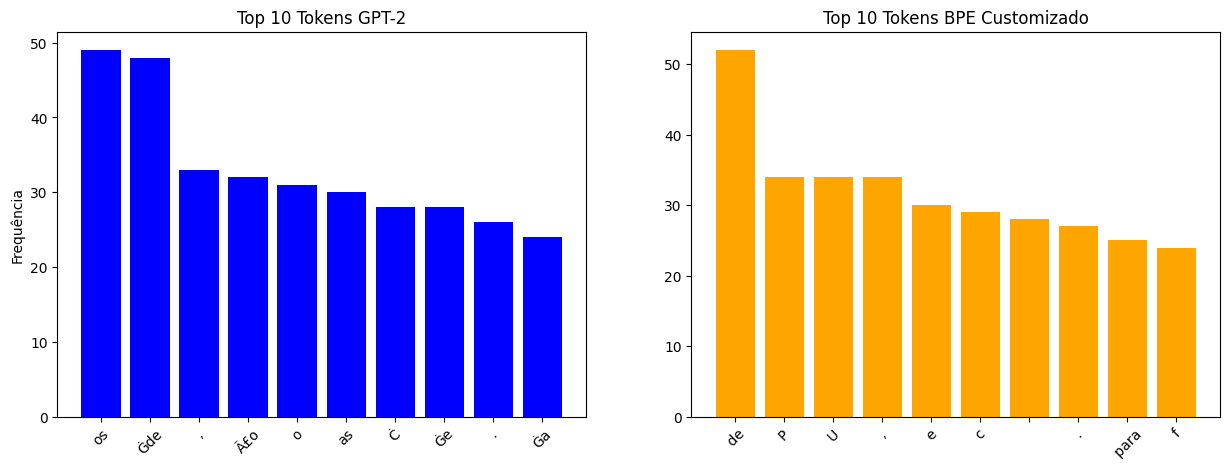

In [183]:
from collections import Counter
import matplotlib.pyplot as plt

# Frequência dos tokens GPT-2
gpt2_token_freq = Counter(gpt2_tokens)
gpt2_most_common = gpt2_token_freq.most_common(10)

# Frequência dos tokens BPE Customizado (decodificar cada token para visualização)
bpe_decoded_tokens = tokenizer.tokenize(text_cpu_gpu)  # Obtém os tokens decodificados em texto
bpe_token_freq = Counter(bpe_decoded_tokens)
bpe_most_common = bpe_token_freq.most_common(10)

# Preparação para visualização dos tokens e suas frequências
gpt2_labels, gpt2_counts = zip(*gpt2_most_common)
bpe_labels, bpe_counts = zip(*bpe_most_common)

# Criação do gráfico lado a lado
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Gráfico para os tokens GPT-2
ax1.bar(gpt2_labels, gpt2_counts, color='blue')
ax1.set_title('Top 10 Tokens GPT-2')
ax1.set_ylabel('Frequência')
ax1.set_xticklabels(gpt2_labels, rotation=45)

# Gráfico para os tokens BPE Customizado
ax2.bar(bpe_labels, bpe_counts, color='orange')
ax2.set_title('Top 10 Tokens BPE Customizado')
ax2.set_xticklabels(bpe_labels, rotation=45)

plt.show()


Vamos estressar esse tokenizador um pouco mais, treinando com uma maior parcela do texto e para um vocabulário 2.5x maior (5000 tokens)